**Original author:  Camilo J. Torres             
        created:  September of 2023            
          email:  <camilo.torres@cern.ch>**

Version created to translate and improve the C++ programm originally written  by Juan A. Garzon <juanantonio.garzon@usc.es> to analyze clusters in the detector due to showers of particles that reach the earth.

In [40]:
# Import the libraries
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ROOT

## Cosmic Ray Showers and Particles Properties

In [41]:
# Primary cosmic ray properties
mpcr = 1       # A mass of primary cosmic ray: 1, 4, 12, 56
f0 = 1.8E4     # Intercepts H, He, C, Fe: 1.8E4, 5.0E3, 1.0E3, 1.5E3
spindex = 2.7  # Spectral index
zhmin = 0     # Zenith angle min 0, 25, 37, 46, 53
zhmax = 25    # Zenith angle max
dene = 0.25   # Width of the LogEnergy interval generated

# H:  8 Height Intervals: 0, 12, 16, 18, 20, 22, 28, 40, 150 km
# He: 8 Height Intervals: 0, 16, 20, 22, 24, 26, 30, 36, 150 km
# C:  8 Height Intervals: 0, 24, 30, 36, 40, 44, 48, 64, 150 km
# Fe: 8 Height Intervals: 0, 32, 40, 44, 48, 52, 56, 64, 150 km
hmin = 0.
hmax = 150.

nshana = 100000  # Max. N.Showers to analyze
mxshop = 50      # nshana/50; # 100; # Mx. N.Showers to print
mxclup = 50      # 10;  # Mx. N.Clusters/Shw to print
mxparp = 500     # 10; # Mx. N.Particles/Energy to print
eperiod = 0
enemod = 0       # shower period and module to print particles
itsana = 0
ishowp = 0
iclusp = 0       # iCounters

# Data Files
# Simulation with 4 samples
# nh: n alturas. an: num. de intervalo angular
nsamp = 1       # Number of samples per shower.
isami = 1       # N. Initial Sample
gm1 = spindex - 1  # pcr energy distribution decrease factor

# Secondary masses
mele = 0.000511   # GeV
mmu = 0.10566     # GeV
mgam = 0.0        # GeV
mp = 0.9383       # GeV
mn = 0.9396       # GeV
mother = 0.14     # GeV. we assume they are mainly pions

# Cluster size analyzed
dsize = 1.8       # m^2. Size of the square detector 

# Printing options
iprhd = 1         # Index for printing headers. 0=No Print.  1=Print

# Output file names
fout0 = "xmdatp_p_E30b_2m2.txt"  # Particle output
fout1 = "xmdatc_p_E30b_2m2.txt"  # Clusters output
fout2 = "xmdats_p_E30b_2m2.txt"  # Showers output
fout3 = "xmdatm_p_E30b_2m2.txt"  # Main Summary
fout4 = "xmdatr_p_E30b_2m2.txt"  # Cluster Radial distribution
fout5 = "xmdath_p_E30b_2m2.txt"  # Mean Height estimation

## Implementation for a Pandas Data Frame (pdf)

In [42]:
#Read the txt files and convert it to PandasDataFrames

# Data names for particles and showers
file_path_particles = 'DataPrueba/DAT000006_particles.txt'
file_path_showers  =  'DataPrueba/DAT000006_showers.txt'

# Read the text file into a DataFrame (assuming it's tab-delimited)
df_particles  = pd.read_table(file_path_particles)
df_showers    = pd.read_table(file_path_showers)

In [43]:
df_particles.head()

,sh,id,x,y,t,px,py,pz,Psq,ek,zha,aza
0,1,1,20285.70,-5280.860,70347.8,-0.014051,0.000221,0.052103,0.002912,0.053965,0.263442,3.12588
1,1,1,4399.67,-1830.410,70512.6,-0.182562,0.015446,0.487750,0.271468,0.521026,0.359324,3.05719
2,1,1,2697.23,-568.421,70534.3,-0.126190,0.013492,0.323988,0.121074,0.347957,0.373339,3.03508
3,1,1,3323.05,398.663,70528.2,-0.020200,0.002715,0.052752,0.003198,0.056553,0.368697,3.00797
4,1,1,7940.11,1343.910,70477.4,-0.018291,0.003078,0.052332,0.003083,0.055522,0.340619,2.97490


In [44]:
df_showers.head()

,Shower,Energy,Zfirst,Theta,Phi,Particles
0,1,1000,2185890.0,0.365347,3.060980,240
1,2,1000,2163780.0,0.332210,-0.162305,51
2,3,1000,2290380.0,0.289072,2.866950,246
3,4,1000,1349470.0,0.362196,2.716310,32
4,5,1000,1997950.0,0.147476,0.840323,49


Number of particles: 51
xmin = -311328.0, xmax = 407112.0 
ymin = -73386.7, ymax = 347685.0


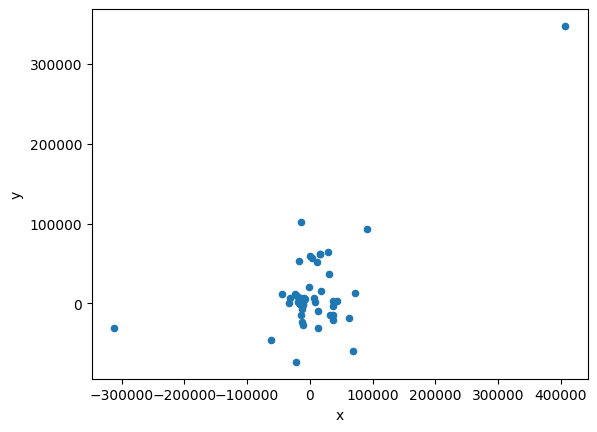

In [56]:
n_shower = 2
df_particles_showercut = df_particles[(df_particles['sh'] == n_shower)]

x_minvalue = df_particles_showercut['x'].min()
x_maxvalue = df_particles_showercut['x'].max()
y_minvalue = df_particles_showercut['y'].min()
y_maxvalue = df_particles_showercut['y'].max()

n_particles = df_showers[(df_showers["Shower"] == n_shower)]["Particles"]

print("Number of particles:", n_particles.iloc[0])

print("xmin = %.1f, xmax = %.1f \nymin = %.1f, ymax = %.1f" % (x_minvalue, x_maxvalue, y_minvalue, y_maxvalue))

ax1 = df_particles_showercut.plot.scatter(x='x',
                                          y='y')

In [58]:
# Create a new column with the cluster id
df_particles_showercut['cluster'] = 0

df_particles_showercut.head()

/tmp/ipykernel_4734/2970146588.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_particles_showercut['cluster'] = 0


,sh,id,x,y,t,px,py,pz,Psq,ek,zha,aza,cluster
240,2,5,8616.0,2066.32,69030.0,23.647700,-3.624650,68.56790,5273.91000,72.51610,0.335702,-0.152093,0
241,2,5,90355.0,92669.60,70460.5,0.550456,0.043034,1.16042,1.65144,1.18376,0.444105,0.078020,0
242,2,6,72115.8,13209.50,69782.0,0.862295,-0.062187,2.05385,4.96573,2.12524,0.398421,-0.071993,0
243,2,6,37026.1,3298.35,69349.7,4.710030,-0.593060,12.70390,183.92500,13.45660,0.357615,-0.125255,0
244,2,5,43527.3,2835.81,69428.7,2.563910,-0.360193,6.75596,52.34640,7.13020,0.365967,-0.139572,0


In [59]:
#x_min = -200000
#x_max = 200000

#y_min = 200000
#y_max = 200000


x_division = math.ceil((np.abs(x_minvalue)+np.abs(x_maxvalue))/30)
y_division = math.ceil((np.abs(y_minvalue)+np.abs(y_maxvalue))/30)

print('x division: %i, y division: %i' % (x_division, y_division))

n_cluster = 1

particles=0
allclusters = 0
multi_cluster = 0

# Loop to move in the x-axis of the particle position grid to search for big clusters
for i in range(30):
    x_max = x_min + x_division

    # Loop to move in the y-axis of the particle position grid to search for big clusters
    for j in range(30):
        y_max = y_min + y_division

        # Cuts to look for particles in the big clusters
        if((x_max == x_maxvalue) and (y_max == y_maxvalue)):
            df_cluster = df_particles_showercut[(df_particles_showercut['x'] >= x_min) & 
                                                (df_particles_showercut['x'] <= x_max) &
                                                (df_particles_showercut['y'] >= y_min) & 
                                                (df_particles_showercut['y'] <= y_max)]
        elif(x_max == x_maxvalue):
            df_cluster = df_particles_showercut[(df_particles_showercut['x'] >= x_min) & 
                                                (df_particles_showercut['x'] <= x_max) &
                                                (df_particles_showercut['y'] >= y_min) & 
                                                (df_particles_showercut['y'] < y_max)]
        elif(y_max == y_maxvalue):
            df_cluster = df_particles_showercut[(df_particles_showercut['x'] >= x_min) & 
                                                (df_particles_showercut['x'] < x_max) &
                                                (df_particles_showercut['y'] >= y_min) & 
                                                (df_particles_showercut['y'] <= y_max)]
        else:
            df_cluster = df_particles_showercut[(df_particles_showercut['x'] >= x_min) & 
                                                (df_particles_showercut['x'] < x_max) &
                                                (df_particles_showercut['y'] >= y_min) & 
                                                (df_particles_showercut['y'] < y_max)]

        
        # --------- Check if the cluster is not empty of particles and fill the clusters ---------

        #
        if((df_cluster.shape[0]==0)):

            y_min = y_max

            if(y_max >= y_maxvalue):
                y_min = y_minvalue
            continue

        # # for one particle that is at the cluster
        elif((df_cluster.shape[0]==1)):
            # Extract the x,y postions of each particle in the cluster
            x_pos = df_cluster['x'].tolist()
            y_pos = df_cluster['y'].tolist()

            # Extract the particle index by comparing it with the x, y position in the data frame
            p_index_clust = df_particles_showercut.index[(df_particles_showercut['x'] == x_pos[0]) & (df_particles_showercut['y'] == y_pos[0])].tolist()

            # Replacte the cluster row of the particle for the cluster id
            df_particles_showercut.at[p_index_clust[0],'cluster'] = n_cluster

            n_cluster+=1 # next cluster
            allclusters+=1
        
        # --------- Check if two or more particles are not in the same cluster ---------
        elif((df_cluster.shape[0]>=2)):
            # Extract the x,y postions of each particle in the cluster
            x_pos = df_cluster['x'].tolist()
            y_pos = df_cluster['y'].tolist()
            
            dist_points = []

            # Check if the distance between all particles in the big cluster is more than 30
            for ii in range(len(x_pos)):

                for jj in range(len(x_pos)-1-ii):

                    dist = np.sqrt((x_pos[ii]-x_pos[ii+jj+1])**2+(y_pos[ii]-y_pos[ii+jj+1])**2)

                    dist_points.append(dist)
                
            cut_dist = min(dist_points)

            # The distance between all the particles in cluster is more than 30 cm
            if(cut_dist > 30*np.sqrt(2)):

                # Create one particle clusters
                for k in range(len(x_pos)):
                    # Extract the particle index by comparing it with the x and y position in the data frame
                    p_index_clust = df_particles_showercut.index[(df_particles_showercut['x'] == x_pos[k]) & (df_particles_showercut['y'] == y_pos[k])].tolist()

                    # Replacte the cluster row of the particle for the cluster id
                    df_particles_showercut.at[p_index_clust[0],'cluster'] = n_cluster

                    n_cluster+=1 # next cluster
                    allclusters+=1

            # Check for clusters with multiple particles
            else:

                x_min_clust = x_min
                y_min_clust = y_min


                # Loop to move in the x-axis of the particle position grid to search for small clusters
                x_division_clust = math.ceil(x_division/30)
                y_division_clust = math.ceil(y_division/30)
                #x_division_clust = x_division/30
                #y_division_clust = y_division/30

                #print(x_division_clust, y_division_clust)

                for m in range(30):
                    x_max_clust = x_min_clust + x_division_clust

                    # Loop to move in the y-axis of the particle position grid to search for small clusters
                    for n in range(30):
                        y_max_clust = y_min_clust + x_division_clust

                        # Cuts to look for particles in the big clusters
                        if((x_max_clust == x_max) and (y_max_clust == y_max)):
                            df_small_cluster = df_particles_showercut[(df_particles_showercut['x'] >= x_min_clust) & 
                                                                (df_particles_showercut['x'] <= x_max_clust) &
                                                                (df_particles_showercut['y'] >= y_min_clust) & 
                                                                (df_particles_showercut['y'] <= y_max_clust)]
                        elif(x_max_clust == x_max):
                            df_small_cluster = df_particles_showercut[(df_particles_showercut['x'] >= x_min_clust) & 
                                                                (df_particles_showercut['x'] <= x_max_clust) &
                                                                (df_particles_showercut['y'] >= y_min_clust) & 
                                                                (df_particles_showercut['y'] < y_max_clust)]
                        elif(y_max_clust == y_max):
                            df_small_cluster = df_particles_showercut[(df_particles_showercut['x'] >= x_min_clust) & 
                                                                (df_particles_showercut['x'] < x_max_clust) &
                                                                (df_particles_showercut['y'] >= y_min_clust) & 
                                                                (df_particles_showercut['y'] <= y_max_clust)]
                        else:
                            df_small_cluster = df_particles_showercut[(df_particles_showercut['x'] >= x_min_clust) & 
                                                                (df_particles_showercut['x'] < x_max_clust) &
                                                                (df_particles_showercut['y'] >= y_min_clust) & 
                                                                (df_particles_showercut['y'] < y_max_clust)]
                            
                        
                        # for one particle that is at the cluster
                        if((df_small_cluster.shape[0]==1)):
                            # Extract the x,y postions of each particle in the cluster
                            x_pos = df_small_cluster['x'].tolist()
                            y_pos = df_small_cluster['y'].tolist()

                            # Extract the particle index by comparing it with the x, y position in the data frame
                            p_index_clust = df_particles_showercut.index[(df_particles_showercut['x'] == x_pos[0]) & (df_particles_showercut['y'] == y_pos[0])].tolist()

                            # Replacte the cluster row of the particle for the cluster id
                            df_particles_showercut.at[p_index_clust[0],'cluster'] = n_cluster

                            n_cluster+=1 # next cluster
                            allclusters+=1

                             # --------- Check if two or more particles are not in the same cluster ---------
                        elif((df_small_cluster.shape[0]>=2)):
                            # Extract the x,y postions of each particle in the cluster
                            x_pos = df_small_cluster['x'].tolist()
                            y_pos = df_small_cluster['y'].tolist()
                            
                            dist_points = []

                            # Check if the distance between all particles in the big cluster is more than 30
                            for ii in range(len(x_pos)):

                                for jj in range(len(x_pos)-1-ii):

                                    dist = np.sqrt((x_pos[ii]-x_pos[ii+jj+1])**2+(y_pos[ii]-y_pos[ii+jj+1])**2)

                                    dist_points.append(dist)
                                
                            cut_dist = min(dist_points)

                            # The distance between all the particles in cluster is more than 30 cm
                            if(cut_dist > 30*np.sqrt(2)):
                                # Create one particle clusters
                                for k in range(len(x_pos)):
                                    # Extract the particle index by comparing it with the x and y position in the data frame
                                    p_index_clust = df_particles_showercut.index[(df_particles_showercut['x'] == x_pos[k]) & (df_particles_showercut['y'] == y_pos[k])].tolist()

                                    # Replacte the cluster row of the particle for the cluster id
                                    df_particles_showercut.at[p_index_clust[0],'cluster'] = n_cluster

                                    n_cluster+=1 # next cluster
                                    allclusters+=1

                            else:
                                #print(df_small_cluster.shape[0])
                                particles=particles+df_small_cluster.shape[0]
                                multi_cluster+=1
                                allclusters+=1
                        

                        y_min_clust = y_max_clust

                        if(y_max_clust >= y_max):
                            y_min_clust = y_min

                    x_min_clust = x_max_clust

                    if(x_max_clust >= x_max):
                        x_min_clust = x_min
                
                    if((x_max_clust >= x_max) and (y_max_clust >= y_max)):
                        break
        
                        
        y_min = y_max

        if(y_max >= y_maxvalue):
            y_min = y_minvalue

    x_min = x_max

    if(x_max >= x_maxvalue):
        x_min = x_minvalue

    if((x_max >= x_maxvalue) and (y_max >= y_maxvalue)):
        break


#print("Particles in Multiclusters:", particles)
print("Number of particles:", n_particles.iloc[0])

print("One particle cluster: ", n_cluster-1)
print("Multi-particle cluster: ", multi_cluster)

print("All clusters: ", allclusters)

x division: 23948, y division: 14036
Number of particles: 51
One particle cluster:  46
Multi-particle cluster:  1
All clusters:  47


In [60]:
df_particles_showercut.head()

,sh,id,x,y,t,px,py,pz,Psq,ek,zha,aza,cluster
240,2,5,8616.0,2066.32,69030.0,23.647700,-3.624650,68.56790,5273.91000,72.51610,0.335702,-0.152093,24
241,2,5,90355.0,92669.60,70460.5,0.550456,0.043034,1.16042,1.65144,1.18376,0.444105,0.078020,43
242,2,6,72115.8,13209.50,69782.0,0.862295,-0.062187,2.05385,4.96573,2.12524,0.398421,-0.071993,41
243,2,6,37026.1,3298.35,69349.7,4.710030,-0.593060,12.70390,183.92500,13.45660,0.357615,-0.125255,35
244,2,5,43527.3,2835.81,69428.7,2.563910,-0.360193,6.75596,52.34640,7.13020,0.365967,-0.139572,40


In [61]:
print(df_particles_showercut[(df_particles_showercut['cluster'] == 0)].shape[0])
df_particles_showercut[(df_particles_showercut['cluster'] == 0)]

6


,sh,id,x,y,t,px,py,pz,Psq,ek,zha,aza,cluster
254,2,5,-43791.0,11763.100,68471.9,2.258850,-0.393747,7.390420,59.875800,7.633010,0.300838,-0.172579,0
258,2,6,-11062.1,-26864.000,68877.1,9.491820,-2.067880,28.393500,900.563000,29.903900,0.329652,-0.214507,0
259,2,6,-33862.2,-164.426,68587.2,4.681220,-0.790737,14.520700,233.390000,15.171800,0.315994,-0.167337,0
261,2,5,-31178.9,6191.950,68618.8,1.287850,-0.208753,4.060700,18.191400,4.160790,0.310872,-0.160696,0
271,2,1,16005.7,62059.500,69321.1,0.022242,0.015373,0.058674,0.004174,0.064604,0.431817,0.604771,0
272,2,3,16005.1,62069.200,69321.1,0.069342,0.036528,0.162237,0.032464,0.179666,0.450026,0.484843,0


## Implementation for a RDataFrame (rdf)

In [50]:
# Convert the PandasDataFrame into a RDataFrame
def pdf_to_rdf(df):
    data = {key: df[key].values for key in df.keys()}
    rdf = ROOT.RDF.MakeNumpyDataFrame(data)
    return rdf

In [51]:
# For particles
rdf_particles = pdf_to_rdf(df_particles)

# For showers
rdf_showers = pdf_to_rdf(df_showers)

In [52]:
rdf_particles.Display().Print()

rdf_showers.Display().Print()

+-----+--------------+-----------+-------------+----+--------------+---------------+-------------+-----+
| Row | Psq          | aza       | ek          | id | px           | py            | pz          | ... | 
+-----+--------------+-----------+-------------+----+--------------+---------------+-------------+-----+
| 0   | 0.0029122400 | 3.1258800 | 0.053965200 | 1  | -0.014051100 | 0.00022084800 | 0.052103400 | ... | 
+-----+--------------+-----------+-------------+----+--------------+---------------+-------------+-----+
| 1   | 0.27146800   | 3.0571900 | 0.52102600  | 1  | -0.18256200  | 0.015446300   | 0.48775000  | ... | 
+-----+--------------+-----------+-------------+----+--------------+---------------+-------------+-----+
| 2   | 0.12107400   | 3.0350800 | 0.34795700  | 1  | -0.12619000  | 0.013492300   | 0.32398800  | ... | 
+-----+--------------+-----------+-------------+----+--------------+---------------+-------------+-----+
| 3   | 0.0031981900 | 3.0079700 | 0.056552600 | 1 

Info in <Print>: Only showing 8 columns out of 13

